# Project Analysis
#### Data Wrangling Project | Matt Lancaster, Advika Shah | 5/3/25

In [1]:
# import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import ttest_rel

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, r2_score, f1_score


In [2]:
# load data_final.csv
final_data = pd.read_csv('data_final.csv', encoding = 'utf-8', index_col = 0)

# change the df settings to not display values in a scientific notation format
pd.options.display.float_format = '{:.2f}'.format

display(final_data.head(5))

,Ticker,Name,Last Sale,Net Change,Percent Change,Market Cap,Share Issued,Total Assets,Net PPE,Accounts Receivable,...,Working Capital,Total Revenue,Operating Income,EBITDA,Net Income,Capital Expenditure,Free Cash Flow,1 Month Stock Price,6 Month Stock Price,1 Year Stock Price
0,AVGO,Broadcom Inc. Common Stock,197.33,4.86,2.52,927835540326.00,4702000000.00,165358000000.00,2465000000.00,4955000000.00,...,80000000.00,14916000000.00,6432000000.00,8537000000.00,5503000000.00,-100000000.00,6013000000.00,154.01,167.59,126.27
1,V,Visa Inc.,342.45,-3.05,-0.88,636195842892.00,1920648651.00,92853000000.00,4023000000.00,2719000000.00,...,2553000000.00,9594000000.00,6435000000.00,5901000000.00,4577000000.00,-327000000.00,4368000000.00,339.39,290.81,266.50
2,XOM,Exxon Mobil Corporation Common Stock,105.78,0.15,0.14,458994579649.00,8019000000.00,451908000000.00,292646000000.00,46303000000.00,...,17404000000.00,81058000000.00,9846000000.00,17507000000.00,7713000000.00,-5898000000.00,7055000000.00,112.43,116.60,112.21
3,HD,"Home Depot, Inc. (The) Common Stock",358.30,-2.19,-0.61,356161725794.00,1800000000.00,96119000000.00,35294000000.00,4319000000.00,...,3022000000.00,39704000000.00,4495000000.00,5534000000.00,2997000000.00,-1101000000.00,3570000000.00,355.91,391.02,334.53
4,PLTR,Palantir Technologies Inc. Class A Common Stock,116.20,-2.24,-1.89,272530425997.00,2338795190.00,6340884000.00,240378000.00,575048000.00,...,4938271000.00,827519000.00,11043000.00,18049000.00,79009000.00,-3106000.00,457221000.00,83.60,41.41,23.33


## Research Question 1:
What is the relationship between company size (market cap) and the percent change in stock price over one year?

In [3]:
# create a column that measures the change in stock price
final_data['pct_change_stock_price'] = (final_data['Last Sale'] - final_data['1 Year Stock Price']) / final_data['1 Year Stock Price']

display(final_data['pct_change_stock_price'])

0      0.56
1      0.28
2     -0.06
3      0.07
4      3.98
       ... 
565    0.05
566    0.08
567    0.01
568    0.03
569    0.06
Name: pct_change_stock_price, Length: 570, dtype: float64

In [4]:
# create market cap quartiles
final_data['cap_quartile'] = pd.qcut(
    final_data['Market Cap'],
    q = 4,
    labels = ['Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap'])


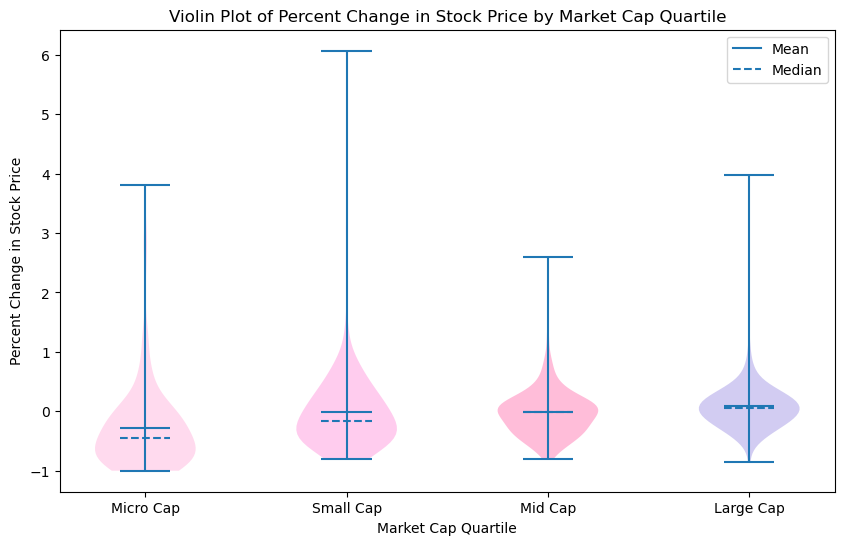

In [5]:
# violin plot for each market cap category to analyze percent change in stock price

quartiles = ['Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap']
data = [final_data[final_data['cap_quartile'] == q]['pct_change_stock_price'].values for q in quartiles]

plt.figure(figsize = (10, 6))
parts = plt.violinplot(data, showmeans=True, showmedians=True)

parts['cmeans'].set_linestyle('-')
parts['cmedians'].set_linestyle('--')

colors = ['#ff86c7', '#ff59c7', '#ff2684', '#6a59d4']
for idx, body in enumerate(parts['bodies']):
    body.set_facecolor(colors[idx])

legend_elements = [Line2D([0], [0], linestyle = '-', label = 'Mean'), Line2D([0], [0], linestyle = '--', label = 'Median')]
plt.legend(handles = legend_elements)

plt.xticks(np.arange(1, 5), quartiles)
plt.xlabel('Market Cap Quartile')
plt.ylabel('Percent Change in Stock Price')
plt.title('Violin Plot of Percent Change in Stock Price by Market Cap Quartile')

plt.show()

## Research Question 2:
How does the average stock price differ among companies categorized by profitability levels?

In [6]:
# create bins for companies based on profitability
bins = [float('-inf'), 0, float('inf')]
labels = ['Unprofitable', 'Profitable']

final_data['Profitability'] = pd.cut(
    final_data['Net Income'],
    bins = bins,
    labels = labels,
    right = True,
    include_lowest = True)

# convert final_data['Profitability'] to a string for further analysis
final_data['Profitability'] = final_data['Profitability'].astype(str)

# For Profitable companies, create three more bins for Marginally Profitable, Profitable, and Highly Profitable
profitable_companies = final_data[final_data['Profitability'] == 'Profitable']

profitable_bins = pd.qcut(
    profitable_companies['Net Income'],
    q = 3,
    labels = ['Marginally Profitable', 'Profitable', 'Highly Profitable'])

# assign these more-specific labels to final_data['Profitability']
final_data.loc[profitable_companies.index, 'Profitability'] = profitable_bins

# For Unprofitable companies, create three more bins for Marginally Unprofitable, Unprofitable, and Highly Unprofitable
unprofitable_companies = final_data[final_data['Profitability'] == 'Unprofitable']

unprofitable_bins = pd.qcut(
    unprofitable_companies['Net Income'],
    q = 3,
    labels = ['Marginally Unprofitable', 'Unprofitable', 'Highly Unprofitable'])

# assign these more-specific labels to final_data['Profitability']
final_data.loc[unprofitable_companies.index, 'Profitability'] = unprofitable_bins

display(final_data[['Ticker', 'Profitability']])


,Ticker,Profitability
0,AVGO,Highly Profitable
1,V,Highly Profitable
2,XOM,Highly Profitable
3,HD,Highly Profitable
4,PLTR,Profitable
...,...,...
565,HLXB,Marginally Profitable
566,HSPO,Marginally Profitable
567,KFII,Highly Unprofitable
568,NETD,Marginally Profitable


In [7]:
# group by Profitability and find the average Last Sale price
avg_price = final_data.groupby('Profitability')['Last Sale'].mean().round(2)

print(avg_price)

Profitability
Highly Profitable         133.28
Highly Unprofitable         6.09
Marginally Profitable      32.11
Marginally Unprofitable    17.70
Profitable                 59.41
Unprofitable                9.39
nan                        92.17
Name: Last Sale, dtype: float64


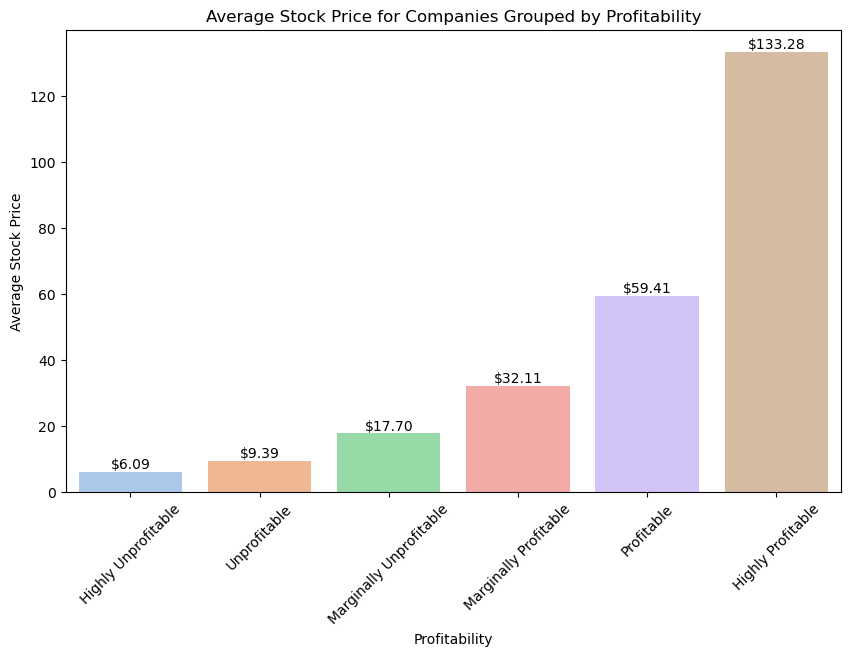

In [8]:
# plot the average Last Sale price by Profitability

# convert avg_price into a df in order to plot
price_by_profit = pd.DataFrame(avg_price)
price_by_profit = price_by_profit.drop('nan', axis = 0)
price_by_profit = price_by_profit.reset_index()

order = ['Highly Unprofitable', 'Unprofitable', 'Marginally Unprofitable', 'Marginally Profitable', 'Profitable', 'Highly Profitable']

plt.figure(figsize = (10,6))
ax = sns.barplot(x = 'Profitability', y = 'Last Sale', data = price_by_profit, order = order, palette = 'pastel')

# include value labels
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"${(height):,.2f}",
            ha='center', va='bottom', fontsize=10, color='black'
        )
plt.title('Average Stock Price for Companies Grouped by Profitability')
plt.xlabel('Profitability')
plt.ylabel('Average Stock Price')
plt.xticks(rotation = 45)

plt.show()

## Research Question 3:
Is there a statistically significant difference between companies' average historical stock prices (one-year vs. one-month and six-month vs. one-month)?


<b>Analyzing trends in companies' historical stock prices - Univariate Analysis</b>

In [9]:
# drop missing values
histogram_data = final_data[['1 Month Stock Price', '6 Month Stock Price', '1 Year Stock Price']].dropna()

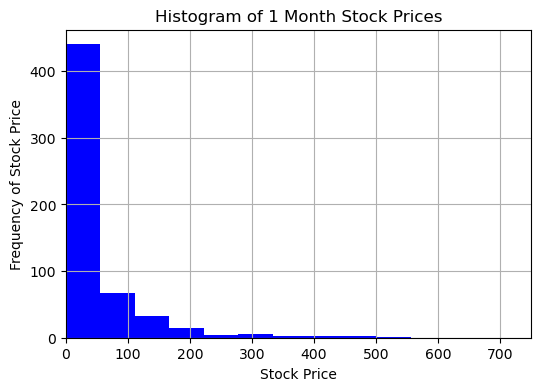

In [10]:
# 1 Month histogram
plt.figure(figsize=(6, 4))
plt.hist(histogram_data['1 Month Stock Price'], color='blue')
plt.title('Histogram of 1 Month Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Frequency of Stock Price')
plt.xlim(0, 750)
plt.grid(True)
plt.show()

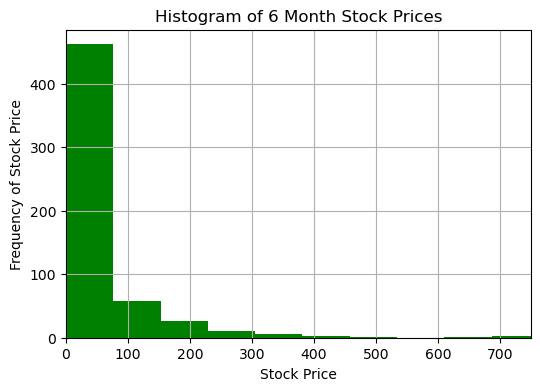

In [11]:
# 6 Month histogram
plt.figure(figsize=(6, 4))
plt.xlim(0, 750)
plt.hist(histogram_data['6 Month Stock Price'], color='green')
plt.title('Histogram of 6 Month Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Frequency of Stock Price')
plt.grid(True)
plt.show()

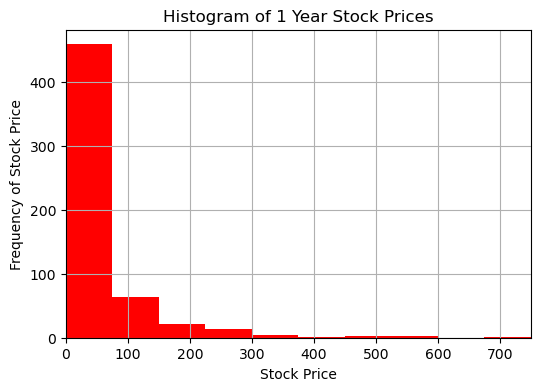

In [12]:
# 1 year histogram
plt.figure(figsize=(6, 4))
plt.xlim(0, 750)
plt.hist(histogram_data['1 Year Stock Price'], bins=100, color='red')
plt.title('Histogram of 1 Year Stock Prices')
plt.xlabel('Stock Price')
plt.ylabel('Frequency of Stock Price')
plt.grid(True)
plt.show()

In [13]:
# paired t-test between 1-month and 6-month stock prices

# drop missing values
price_data = final_data[['1 Month Stock Price', '6 Month Stock Price']].dropna()

t_stat, p_value = ttest_rel(price_data['1 Month Stock Price'], price_data['6 Month Stock Price'])

# print results
print(f"Paired t-test results:\n t-statistic = {t_stat:.3f}\n p-value = {p_value:.3f}")

#interpret results 
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between 1-month and 6-month average stock prices.")
else:
    print("There is no significant difference between 1-month and 6-month average stock prices.")

Paired t-test results:
 t-statistic = -4.651
 p-value = 0.000
There is a significant difference between 1-month and 6-month average stock prices.


In [14]:
# paired t-test between 1-month and 1-year stock prices

# drop missing values
price_data = final_data[['1 Month Stock Price', '1 Year Stock Price']].dropna()

t_stat, p_value = ttest_rel(price_data['1 Month Stock Price'], price_data['1 Year Stock Price'])

# print results
print(f"Paired t-test results:\n t-statistic = {t_stat:.3f}\n p-value = {p_value:.3f}")

# interpret results
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between 1-month and 1-year average stock prices.")
else:
    print("There is no significant difference between 1-month and 1-year average stock prices.")

Paired t-test results:
 t-statistic = -1.425
 p-value = 0.155
There is no significant difference between 1-month and 1-year average stock prices.


## Research Question 4:
To what extent can Total Assets, Total Debt, Net Income, Stockholders' Equity, and Market Capitalization predict the direction of stock price changes?

In [15]:
# create a dummy variable to indicate the direction of stock price changes
# if stock price > 0, pct_change_dummy = 1
final_data['pct_change_dummy'] = (final_data['pct_change_stock_price'] > 0).astype(int)
display(final_data.head(5))


,Ticker,Name,Last Sale,Net Change,Percent Change,Market Cap,Share Issued,Total Assets,Net PPE,Accounts Receivable,...,Net Income,Capital Expenditure,Free Cash Flow,1 Month Stock Price,6 Month Stock Price,1 Year Stock Price,pct_change_stock_price,cap_quartile,Profitability,pct_change_dummy
0,AVGO,Broadcom Inc. Common Stock,197.33,4.86,2.52,927835540326.00,4702000000.00,165358000000.00,2465000000.00,4955000000.00,...,5503000000.00,-100000000.00,6013000000.00,154.01,167.59,126.27,0.56,Large Cap,Highly Profitable,1
1,V,Visa Inc.,342.45,-3.05,-0.88,636195842892.00,1920648651.00,92853000000.00,4023000000.00,2719000000.00,...,4577000000.00,-327000000.00,4368000000.00,339.39,290.81,266.50,0.28,Large Cap,Highly Profitable,1
2,XOM,Exxon Mobil Corporation Common Stock,105.78,0.15,0.14,458994579649.00,8019000000.00,451908000000.00,292646000000.00,46303000000.00,...,7713000000.00,-5898000000.00,7055000000.00,112.43,116.60,112.21,-0.06,Large Cap,Highly Profitable,0
3,HD,"Home Depot, Inc. (The) Common Stock",358.30,-2.19,-0.61,356161725794.00,1800000000.00,96119000000.00,35294000000.00,4319000000.00,...,2997000000.00,-1101000000.00,3570000000.00,355.91,391.02,334.53,0.07,Large Cap,Highly Profitable,1
4,PLTR,Palantir Technologies Inc. Class A Common Stock,116.20,-2.24,-1.89,272530425997.00,2338795190.00,6340884000.00,240378000.00,575048000.00,...,79009000.00,-3106000.00,457221000.00,83.60,41.41,23.33,3.98,Large Cap,Profitable,1


In [16]:
# testing and training set using 80/20 split

clean_data = final_data.dropna()
X = clean_data[['Total Assets', 'Total Debt', 'Net Income', 'Stockholders Equity', 'Market Cap']]
y = clean_data['pct_change_dummy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [17]:
# create an empty df to store the results from the machine learning models
results = pd.DataFrame(columns = ['Machine Learning Method', 'Accuracy', 'F-1 Score'])


In [18]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 7)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

score_result = knn.score(X_test, y_test)
f1_result = f1_score(y_test, y_pred, average = 'weighted')

results.loc[len(results)] = ['KNN', score_result, f1_result]
print('Accuracy:', score_result)
print('F-1 Score:', f1_result)
display(results)

Accuracy: 0.5633802816901409
F-1 Score: 0.5739197087285619


,Machine Learning Method,Accuracy,F-1 Score
0,KNN,0.56,0.57


In [19]:
# Decision Tree
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

score_result = dt.score(X_test, y_test)
f1_result = f1_score(y_test, y_pred, average = 'weighted')

results.loc[len(results)] = ['Decision Tree', score_result, f1_result]
print('Accuracy:', score_result)
print('F-1 Score:', f1_result)
display(results)


Accuracy: 0.5633802816901409
F-1 Score: 0.5765513139166826


,Machine Learning Method,Accuracy,F-1 Score
0,KNN,0.56,0.57
1,Decision Tree,0.56,0.58


In [20]:
# SVC 
svc = SVC()

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

score_result = svc.score(X_test, y_test)
f1_result = f1_score(y_test, y_pred, average = 'weighted')

results.loc[len(results)] = ['SVC', score_result, f1_result]
print('Accuracy:', score_result)
print('F-1 Score:', f1_result)
display(results)


Accuracy: 0.7323943661971831
F-1 Score: 0.6524328879258456


,Machine Learning Method,Accuracy,F-1 Score
0,KNN,0.56,0.57
1,Decision Tree,0.56,0.58
2,SVC,0.73,0.65


In [21]:
# logistic regression
log_reg = LogisticRegression(max_iter = 1000)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

score_result = log_reg.score(X_test, y_test)
f1_result = f1_score(y_test, y_pred, average = 'weighted')

results.loc[len(results)] = ['Logistic Regression', score_result, f1_result]
print('Accuracy:', score_result)
print('F-1 Score:', f1_result)
display(results)


Accuracy: 0.4647887323943662
F-1 Score: 0.47979866377753705


,Machine Learning Method,Accuracy,F-1 Score
0,KNN,0.56,0.57
1,Decision Tree,0.56,0.58
2,SVC,0.73,0.65
3,Logistic Regression,0.46,0.48


## Research Question 5:
Can key financial indicators (Net Income, Stockholders' Equity, Market Capitalization, Total Debt, Total Assets, and Cash and Cash Equivalents) be used to predict whether a company has more Accounts Payable than Accounts Receiveable?

In [22]:
# creating a dummy variable to indiciate if Accounts Receivable > Accounts Payable
# if  Accounts Receivable > Accounts Payable, pct_change_dummy = 1

final_data['accounts_dummy'] = (final_data['Accounts Receivable'] > final_data['Accounts Payable']).astype(int)
display(final_data.head(5))

,Ticker,Name,Last Sale,Net Change,Percent Change,Market Cap,Share Issued,Total Assets,Net PPE,Accounts Receivable,...,Capital Expenditure,Free Cash Flow,1 Month Stock Price,6 Month Stock Price,1 Year Stock Price,pct_change_stock_price,cap_quartile,Profitability,pct_change_dummy,accounts_dummy
0,AVGO,Broadcom Inc. Common Stock,197.33,4.86,2.52,927835540326.00,4702000000.00,165358000000.00,2465000000.00,4955000000.00,...,-100000000.00,6013000000.00,154.01,167.59,126.27,0.56,Large Cap,Highly Profitable,1,1
1,V,Visa Inc.,342.45,-3.05,-0.88,636195842892.00,1920648651.00,92853000000.00,4023000000.00,2719000000.00,...,-327000000.00,4368000000.00,339.39,290.81,266.50,0.28,Large Cap,Highly Profitable,1,1
2,XOM,Exxon Mobil Corporation Common Stock,105.78,0.15,0.14,458994579649.00,8019000000.00,451908000000.00,292646000000.00,46303000000.00,...,-5898000000.00,7055000000.00,112.43,116.60,112.21,-0.06,Large Cap,Highly Profitable,0,0
3,HD,"Home Depot, Inc. (The) Common Stock",358.30,-2.19,-0.61,356161725794.00,1800000000.00,96119000000.00,35294000000.00,4319000000.00,...,-1101000000.00,3570000000.00,355.91,391.02,334.53,0.07,Large Cap,Highly Profitable,1,0
4,PLTR,Palantir Technologies Inc. Class A Common Stock,116.20,-2.24,-1.89,272530425997.00,2338795190.00,6340884000.00,240378000.00,575048000.00,...,-3106000.00,457221000.00,83.60,41.41,23.33,3.98,Large Cap,Profitable,1,1


In [23]:
# testing and training set using 80/20 split
clean_data2 = final_data.dropna()
X = clean_data2[['Total Debt', 'Total Assets','Cash And Cash Equivalents','Stockholders Equity','Net Income','Market Cap']]
y = clean_data2['accounts_dummy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


In [24]:
# creating an empty df to store the results from the machine learning models 
results2 = pd.DataFrame(columns=['Machine Learning Method', 'Accuracy', 'F-1_Score'])


In [25]:
# KNN
knn = KNeighborsClassifier(n_neighbors= 7)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

knn_result = knn.score(X_test, y_test)
f1_result = f1_score(y_test, y_pred, average='weighted')

results2.loc[len(results2)] = ['KNN', knn_result, f1_result]

print("Accuracy:", knn_result)
print ("F-1 score:", f1_result)
display(results2)


Accuracy: 0.647887323943662
F-1 score: 0.6198271493243451


,Machine Learning Method,Accuracy,F-1_Score
0,KNN,0.65,0.62


In [26]:
# Decision Trees
decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

score_result = decision_tree.score(X_test, y_test)
f1_result = f1_score(y_test, y_pred, average='weighted')

results2.loc[len(results2)] = ['Decision Tree', score_result, f1_result]

print("Accuracy:", score_result)
print ("F-1 score:", f1_result)
display(results2)


Accuracy: 0.5915492957746479
F-1 score: 0.5931079374274053


,Machine Learning Method,Accuracy,F-1_Score
0,KNN,0.65,0.62
1,Decision Tree,0.59,0.59


In [27]:
# SVC
svc = SVC()

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

score_result = svc.score(X_test, y_test)
f1_result = f1_score(y_test, y_pred, average='weighted')

results2.loc[len(results2)] = ['SVC', score_result, f1_result]

print("Accuracy:", score_result )
print ("F-1 score:", f1_result )
display(results2)


Accuracy: 0.6338028169014085
F-1 score: 0.4917435648372997


,Machine Learning Method,Accuracy,F-1_Score
0,KNN,0.65,0.62
1,Decision Tree,0.59,0.59
2,SVC,0.63,0.49


In [28]:
# logistic regression
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

score_result = log_reg.score(X_test, y_test)
f1_result = f1_score(y_test, y_pred, average='weighted')

results2.loc[len(results2)] = ['Logistic Regression', score_result, f1_result]

print("Accuracy:", score_result )
print ("F-1 score:", f1_result )
display (results2)


Accuracy: 0.36619718309859156
F-1 score: 0.196311891970379


/Users/mattlancaster/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Machine Learning Method,Accuracy,F-1_Score
0,KNN,0.65,0.62
1,Decision Tree,0.59,0.59
2,SVC,0.63,0.49
3,Logistic Regression,0.37,0.20
